In [8]:
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist

In [9]:
def hopfield_train(X):
    X = X.reshape(X.shape[0], -1)

    # Initialize weights with zeros
    weights = np.zeros((X.shape[1], X.shape[1]))

    # For each value in the input
    for pattern in X:
        weights += np.outer(pattern, pattern)
    """     for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            weights[i, j] = np.sum(X[:, i] * X[:, j]) / X.shape[1] """

    # Remove the diagonal to eliminate self-connections
    np.fill_diagonal(weights, 0)
    return weights

def hopfield_recall(X, weights, epochs=1000):
    X = X.flatten()
    
    for _ in range(epochs):
    #while True:
        prediction = np.dot(weights, X)
        # If the value is smaller than 0, set it to -1, otherwise set it to 1
        prediction = np.where(prediction < 0, -1, 1)

        # If the prediction is the same as the input, stop the loop
        if np.array_equal(prediction, X):
            print("Converged after", _ + 1, "epochs")
            return prediction

        X = prediction

    return X

def compress_image_mean(img_array, block_size):
    """
    Compress an image by calculating the mean of each block of pixels of size block_size x block_size.

    Parameters
    ----------
    img_array : array
        The input image as a numpy array
    block_size : int
        The size of the blocks to compress the image

    Returns
    -------
    compressed_img_array : array
        The compressed image as a numpy array
    """
    # Get the original dimensions
    original_height, original_width = img_array.shape[:2]
    
    # Calculate new dimensions
    new_height = original_height // block_size
    new_width = original_width // block_size
    
    # Initialize the compressed image array
    compressed_img_array = np.zeros((new_height, new_width), dtype=np.uint8)
    
    # Compress the image by calculating the mean of each block
    for i in range(new_height):
        for j in range(new_width):
            block = img_array[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_mean = block.mean(axis=(0, 1))
            compressed_img_array[i, j] = block_mean
    
    return compressed_img_array

In [10]:
digits_to_classify = [0, 1, 2, 3]

num_examples = len(digits_to_classify)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Obtain one example of each digit
#training_data = np.array([X_train[y_train == i][0] for i in range(num_examples)])
training_data = np.array([X_train[y_train == i][np.random.randint(0, len(X_train[y_train == i]))] for i in digits_to_classify])

# Obtain a random example from the range of examples
test = np.array(X_test[y_test == np.random.choice(digits_to_classify)][0])
#test = training_data[np.random.randint(0, num_examples)]

training_data.shape

(4, 28, 28)

In [11]:
# Reduce the size of the image
block_size = 1

if block_size > 1 and block_size < training_data[0].shape[0]:
    training = np.zeros((num_examples, training_data[0].shape[0] // block_size, training_data[0].shape[1] // block_size), dtype=np.uint8)
    for i, training_example in enumerate(training_data):
        training[i] = compress_image_mean(training_example, block_size)
    test = compress_image_mean(test, block_size)
else:
    training = training_data

training[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 145,
        210, 166,  25, 148, 148,  78,  25,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15, 165, 248,
        253, 253, 202, 253, 253, 253, 227,  72,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [12]:
# Transfrom the data to binary
treshold = np.mean(training)
training = np.where(training > treshold, 1, -1)
test = np.where(test > treshold, 1, -1)

# Remove the pixels in the border that are the same for all examples
""" training = training[:, 4:-4, 4:-4]
test = test[4:-4, 4:-4] """

' training = training[:, 4:-4, 4:-4]\ntest = test[4:-4, 4:-4] '

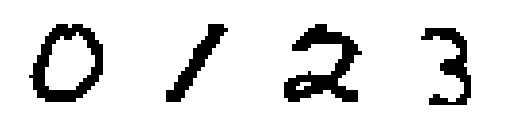

In [13]:
img_size = training[0].shape
# Plot the first num examples
fig, ax = plt.subplots(1, num_examples)
for i in range(num_examples):
    #Remove axis and labels
    ax[i].axis('off')
    ax[i].imshow(training[i].reshape(img_size), cmap='Greys')

plt.show()

Converged after 2 epochs


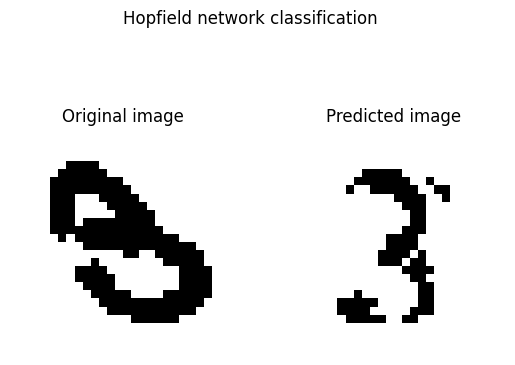

In [14]:
# Train the network
w = hopfield_train(training)
pred = hopfield_recall(test, w, epochs=1000)

# Create a figure with 2 images inside
fig, ax = plt.subplots(1, 2)
fig.suptitle("Hopfield network classification")
ax[0].set_title("Original image")
ax[0].axis('off')
ax[0].imshow(test.reshape(img_size), cmap='Greys')
ax[1].set_title("Predicted image")
ax[1].axis('off')
ax[1].imshow(pred.reshape(img_size), cmap='Greys')
plt.show()